## Using a gym simulation environment

### OpenAI Gym


In [16]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random

#### initialize the environment

In [17]:
env = gym.make("CartPole-v1", render_mode="rgb_array")  # render needs to be declared
print("env.action_space: ", env.action_space)
print("env.observation_space: ", env.observation_space)
print("env.action_space.sample(): ", env.action_space.sample())

print("env.observation_space.low: ", env.observation_space.low)
print("env.observation_space.high: ", env.observation_space.high)

env.action_space:  Discrete(2)
env.observation_space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
env.action_space.sample():  1
env.observation_space.low:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
env.observation_space.high:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [38]:
# env.reset()
# frame = env.render()           # ← ndarray, shape (400, 600, 3)
# plt.imshow(frame)
# plt.axis("off")                # optional
# plt.show()

def show_animation(frame):
    plt.imshow(frame)
    plt.axis("off")
    display.display(plt.gcf())
    display.clear_output(wait=True)  # overwrite previous frame
    time.sleep(1 / 30)

####  run a short simulation

In [46]:
from IPython import display
import time

cum_rew = 0
obs, info = env.reset(seed=42)  # reset returns (obs, info)
for i in range(100):
    frame = env.render()
    # show_animation(frame)
    obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
    cum_rew += rew
print('reward:', cum_rew)

reward: 19.0


### State discretization

#### create function to discretize observations

In [21]:
def discretize(x):
    return tuple((x / np.array([0.25, 0.25, 0.01, 0.1])).astype(int))


def create_bins(i, num):
    return np.arange(num + 1) * (i[1] - i[0]) / num + i[0]


print("Sample bins for interval (-5,5) with 10 bins\n", create_bins((-5, 5), 10))

ints = [(-5, 5), (-2, 2), (-0.5, 0.5), (-2, 2)]  # intervals of values for each parameter
nbins = [20, 20, 10, 10]  # number of bins for each parameter
bins = [create_bins(ints[i], nbins[i]) for i in range(4)]


def discretize_bins(x):
    return tuple(np.digitize(x[i], bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


#### run simulation to observe discrete environment values

In [22]:
env.reset()
for _ in range(20):
    env.render()
    obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
    print(obs)
    print(discretize_bins(obs))
    # print(discretize(obs))

[-0.03963102 -0.14792429  0.0266861   0.32941288]
(np.int64(10), np.int64(10), np.int64(6), np.int64(6))
[-0.04258951 -0.34341577  0.03327436  0.63039047]
(np.int64(10), np.int64(9), np.int64(6), np.int64(7))
[-0.04945782 -0.14877352  0.04588217  0.34836957]
(np.int64(10), np.int64(10), np.int64(6), np.int64(6))
[-0.05243329  0.04566683  0.05284956  0.0705006 ]
(np.int64(10), np.int64(11), np.int64(6), np.int64(6))
[-0.05151996  0.23999283  0.05425957 -0.20505087]
(np.int64(10), np.int64(12), np.int64(6), np.int64(5))
[-0.0467201   0.43429855  0.05015855 -0.48013604]
(np.int64(10), np.int64(13), np.int64(6), np.int64(4))
[-0.03803413  0.23850575  0.04055583 -0.17207576]
(np.int64(10), np.int64(12), np.int64(6), np.int64(5))
[-0.03326401  0.04282752  0.03711431  0.13312039]
(np.int64(10), np.int64(11), np.int64(6), np.int64(6))
[-0.03240746  0.23739873  0.03977672 -0.14762634]
(np.int64(10), np.int64(12), np.int64(6), np.int64(5))
[-0.02765949  0.43192914  0.0368242  -0.4274999 ]
(np.in

### The Q-Table structure

In [23]:
Q = {}
actions = (0, 1)

# returns a list of Q-Table values for a given state that corresponds to all possible actions.
def qvalues(state):
    return [Q.get((state, a), 0) for a in actions]

### start Q-Learning

#### set hyperparameters


In [24]:
alpha = 0.3
gamma = 0.9
epsilon = 0.90


def probs(v, eps=1e-4):
    v = v - v.min() + eps
    v = v / v.sum()
    return v

#### start the learning loop

In [ ]:
Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(1000):
    obs, info = env.reset()
    done = False
    cum_reward = 0
    # == do the simulation ==
    while not done:
        s = discretize(obs)
        if random.random() < epsilon:
            # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions, weights=v)[0]
        else:
            # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        obs, rew, terminated, truncated, info = env.step(a)
        cum_reward += rew
        ns = discretize(obs)
        Q[(s, a)] = (1 - alpha) * Q.get((s, a), 0) + alpha * (rew + gamma * max(qvalues(ns)))
        # show_animation(env.render())
        # print('cum_reward: ', cum_reward, ' rew:' , rew, ' s: ', s, ' action: ', a)
        if cum_reward >= 100:
            done = True
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    print('start learning ', epoch)
    # == Periodically print results and calculate average reward ==
    # if epoch % 500 == 0:
    #     print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
    #     if np.average(cum_rewards) > Qmax:
    #         Qmax = np.average(cum_rewards)
    #         Qbest = Q
    #     cum_rewards = []

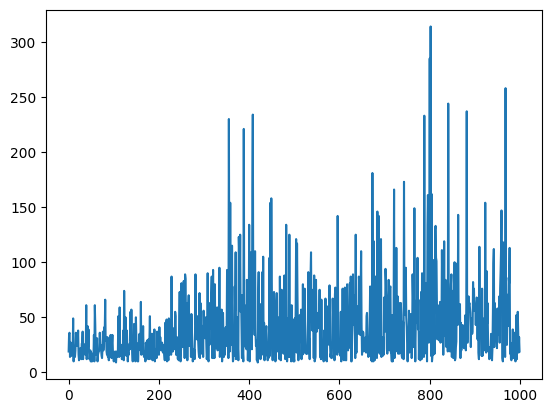

In [31]:
plt.plot(rewards)


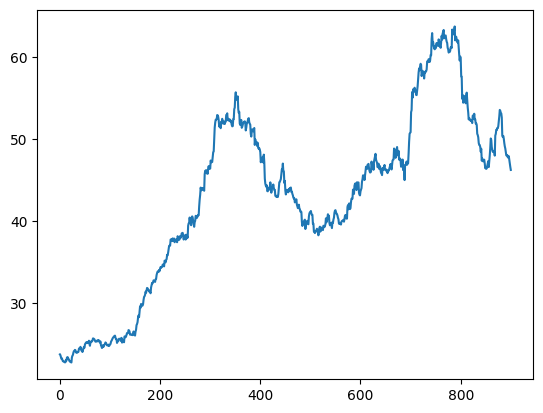

In [32]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,100))

### see how the trained model behaves

In [50]:
obs, info = env.reset()
cum_rew = 0
for i in range(100):
    s = discretize(obs)
    # show_animation(env.render())
    v = probs(np.array(qvalues(s)))
    a = random.choices(actions,weights=v)[0]
    obs, rew, terminated, truncated, info = env.step(a)
    cum_rew += rew
print('reward:', cum_rew)
env.close()

reward: 26.0
